<a href="https://colab.research.google.com/github/chowski3/assignment4/blob/main/Adam_Chow_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible



In [2]:
! git  clone https://www.github.com/DS3001/assignment4

Cloning into 'assignment4'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (8/8), 265.63 KiB | 4.02 MiB/s, done.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree # Import the tree classifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Import linear regression model

In [4]:
# 1 Load the ./data/cars_hw.csv data. Look at the head and dimensions of the data.
car_df = pd.read_csv('./assignment4/data/cars_hw.csv')
car_df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [5]:
# Checking to see if any values need to be switch to NaN
car_df['Make'].unique()
car_df['Color'].unique()
car_df['Body_Type'].unique()
car_df['No_of_Owners'].unique()
car_df['Fuel_Type'].unique() # categories 'petrol' and 'petrol+cng'
car_df['Transmission'].unique()
car_df['Transmission_Type'].unique()

array(['Automatic', 'Manual'], dtype=object)

In [6]:
# Replace 'petrol+cng' with 'petrol' in the 'Fuel_Type' column
car_df['Fuel_Type'] = car_df['Fuel_Type'].replace('petrol+cng', 'petrol')

# arcsinh transform 'Price Variable'
car_df['Price'] = np.arcsinh(car_df['Price'])

# Drop 'Unnamed:' column
car_df = car_df.drop(columns='Unnamed: 0')

# Convert 'No_of_Owners' to numeric
car_df['No_of_Owners'] = car_df['No_of_Owners'].replace({'1st': 1, '2nd': 2, '3rd': 3})

# Take out Price Outliers
Q1 = car_df['Price'].quantile(0.25)
Q3 = car_df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

car_df = car_df[(car_df['Price'] >= lower_bound) & (car_df['Price'] <= upper_bound)]

# Look at head
car_df.head(10)

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,14.088586
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,14.125932
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,14.276726
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,13.626768
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,13.845069
5,Hyundai,2016,red,hatchback,52261,1,5,petrol,5-Speed,Manual,14.004477
6,Honda,2012,grey,hatchback,28108,2,5,petrol,5-Speed,Manual,13.356645
7,Tata,2019,grey,suv,92603,1,5,diesel,6-Speed,Automatic,14.858610
8,Hyundai,2021,blue,hatchback,16304,1,5,petrol,5-Speed,Manual,14.166167
9,Renault,2019,bronze,hatchback,26350,2,5,petrol,5-Speed,Manual,13.572164


count    974.000000
mean      14.103958
std        0.446380
min       13.068963
25%       13.766845
50%       14.102942
75%       14.383944
max       15.250595
Name: Price, dtype: float64


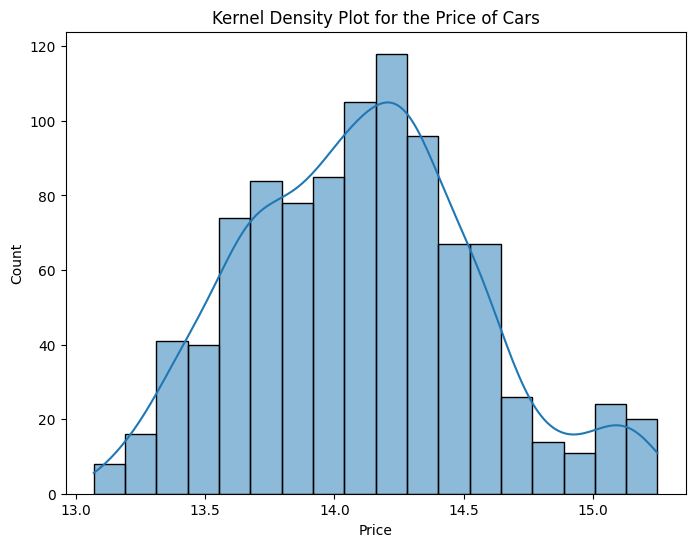

In [7]:
# 2
# Describe Price Variable
print(car_df['Price'].describe())

# Price Kernel Density Plot
plt.figure(figsize=(8, 6))
sns.histplot(car_df['Price'], kde=True)
plt.title('Kernel Density Plot for the Price of Cars')
plt.xlabel('Price')
plt.show()

               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  13.613042  0.480975  13.188151  13.261539  13.445433   
Datsun           3.0  13.269194  0.036311  13.232114  13.251449  13.270783   
Ford            52.0  14.161427  0.210895  13.270783  14.054527  14.162640   
Honda           73.0  14.229465  0.336972  13.356645  13.965653  14.266586   
Hyundai        305.0  14.061658  0.398781  13.114331  13.785051  14.059241   
Jeep             4.0  14.909738  0.105084  14.763300  14.876417  14.933413   
Kia              8.0  14.985324  0.076877  14.822738  14.965389  14.996253   
MG Motors       35.0  15.132199  0.066263  14.971763  15.088892  15.122762   
Mahindra        18.0  14.592100  0.159906  14.280502  14.544955  14.598828   
Maruti Suzuki  293.0  13.911280  0.371409  13.068963  13.619496  13.868103   
Nissan           4.0  14.334341  0.392610  13.764217  14.230922 

<ipython-input-8-95c719ca98b0>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Price'], label=make, shade=False)
<ipython-input-8-95c719ca98b0>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Price'], label=make, shade=False)
<ipython-input-8-95c719ca98b0>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Price'], label=make, shade=False)
<ipython-input-8-95c719ca98b0>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Price'], label=make, shade=False)
<ipython-input-8-95c

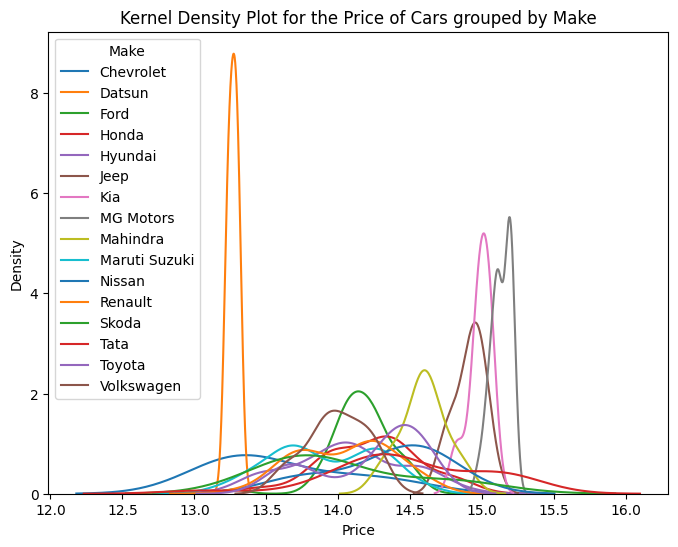

In [8]:
# 2 cont.

# Summarize 'Prices', grouping by 'Make'
print(car_df.groupby('Make')['Price'].describe())

# Kernel Density Plot group by Make
plt.figure(figsize=(8, 6))
for make, data in car_df.groupby('Make'):
    sns.kdeplot(data['Price'], label=make, shade=False)


plt.title('Kernel Density Plot for the Price of Cars grouped by Make')
plt.xlabel('Price')
plt.legend(title='Make')
plt.show()


**Which car brands are the most expensive?**
When removing all of the outliers, MG Motors, KIA, and Jeep, are the overall most expensive car brands. However, specifically KIA and Jeep only have less than 10 cars in this dataset, not giving us an adequate sample size to confirm this possible trend. So, out of all of the brands with a count of 10+ cars, MG Motors, Mahindra, Toyota, and Honda were the most expensive.

**What do prices look like in general?**
Most of these prices are hovering around 500,000 - 8,000,000. There were a few outliers in the 1,000,000 range and a few in the 200,000 and 400,000 range. However, with the arcsinh transformation, all of the brands are now within 13.8 - 15.1. This adjustment is clearly depicted in the kde plot that appears to look approximately normally distributed.

In [9]:
# 3 - Split Dataset
# Split the data into an 80% training set and a 20% testing set
'''
X = car_df.drop(columns=['Price'])
y = car_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''
# Define features (X) and target variable (y)
X_numeric = car_df.select_dtypes(include='number').drop(columns=['Price'])
X_categorical = car_df.select_dtypes(exclude='number')
y = car_df['Price']

# Split the data into an 80% training set and a 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

In [10]:
#4 - Create Linear Model

num_vars = ['Seating_Capacity','Mileage_Run','Make_Year', 'No_of_Owners']

# Model 1: Regression on Numeric Variables
model_numeric = LinearRegression()
model_numeric.fit(X_train, y_train)

# Predict on the test set
y_pred_numeric = model_numeric.predict(X_test)

# Evaluate model 1
r2_numeric = r2_score(y_test, y_pred_numeric)
rmse_numeric = mean_squared_error(y_test, y_pred_numeric, squared=False)

print("Model 1 - Regression on Numeric Variables:")
print("R-squared:", r2_numeric)
print("RMSE:", rmse_numeric)

Model 1 - Regression on Numeric Variables:
R-squared: 0.3665856857094715
RMSE: 0.345636989717336


In [11]:
#4 cont. - Categorical

# Model 2: Regression on One-Hot Encoded Categorical Variables

# One-hot encode categorical variables
X_categorical_ohe = pd.get_dummies(X_categorical)

# Split data
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_categorical_ohe, y, test_size=0.2, random_state=42)

model_ohe = LinearRegression()
model_ohe.fit(X_train_ohe, y_train)

# Evaluate on the test set
y_pred_ohe = model_ohe.predict(X_test_ohe)
r2_ohe = r2_score(y_test, y_pred_ohe)
rmse_ohe = mean_squared_error(y_test, y_pred_ohe, squared=False)

print("Model 2 - Regression on One-Hot Encoded Categorical Variables:")
print("R-squared:", r2_ohe)
print("RMSE:", rmse_ohe)

Model 2 - Regression on One-Hot Encoded Categorical Variables:
R-squared: 0.5985375222605338
RMSE: 0.27516852607437764


**Which model performs better on the test set?**

Out of the two models, numeric and categorical, the categorical model definitely proves to be the more accurate of the two models with a 0.59 R^2 (higher) and a 0.27 RMSE (lower).

In [12]:
# 4 cont. - Combined

# Define a transformer for one-hot encoding categorical variables
categorical_features = X_categorical.columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined numeric and categorical preprocessor
preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X_numeric.columns),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessor and model
model_combined = Pipeline(steps=[
    ('preprocessor', preprocessor_combined),
    ('regressor', LinearRegression())
])

# Join numeric and categorical datasets
X_train_combined = X_train.join(X_categorical)
X_test_combined = X_test.join(X_categorical)

# Fit on combined training data
model_combined.fit(X_train_combined, y_train)

# Predict on combined test data
y_pred_combined = model_combined.predict(X_test_combined)

# Evaluate combined model
r2_combined = r2_score(y_test, y_pred_combined)
rmse_combined = mean_squared_error(y_test, y_pred_combined, squared=False)

print("\nModel 3 - Combined Numeric and Categorical Variables:")
print("R-squared:", r2_combined)
print("RMSE:", rmse_combined)



Model 3 - Combined Numeric and Categorical Variables:
R-squared: 0.7730479782359172
RMSE: 0.20689181292822498


**Does the joint model perform better or worse, and by how much?**

This new joint model model performs significantly better than the previous two models, notching a 0.74 R^2 and a 0.22 RMSE. Compared to the better of the two models - categorical - there is a 0.2 increase in the R^2 and a 0.08 decrease in RMSE, both extremely positive signs of improvement.

In [25]:
# 5
# Degree of polynomial expansion
degrees = [1,2,3,4,5,6,7,8,9,10]

for degree in degrees:

  # Create pipeline
  pipe = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                   ('linreg', LinearRegression())])

  # Fit to training data
  pipe.fit(X_train, y_train)

  # Predict on test data
  y_pred = pipe.predict(X_test)

  # Evaluate
  poly_r2 = pipe.score(X_test, y_test)
  poly_rmse = mean_squared_error(y_test, y_pred, squared=False)

  print("Degree {}: R2={}, RMSE={}".format(degree, poly_r2, np.sqrt(poly_rmse)))


Degree 1: R2=0.36658568570948713, RMSE=0.5879089978196725
Degree 2: R2=0.4451376595980473, RMSE=0.5687670790880944
Degree 3: R2=0.4483236698902162, RMSE=0.567948852365486
Degree 4: R2=0.4314167420263778, RMSE=0.5722511255323333
Degree 5: R2=0.4393215215165983, RMSE=0.5702517282430944
Degree 6: R2=0.41354292678539517, RMSE=0.5766963408113824
Degree 7: R2=0.40712370542731935, RMSE=0.5782679999813668
Degree 8: R2=-0.6668767431344897, RMSE=0.7487968528533938
Degree 9: R2=0.3469526753506912, RMSE=0.5924126209189537
Degree 10: R2=0.28860333447648745, RMSE=0.6052239350583181


**As you increase the degree of the expansion, how do the  𝑅2  and RMSE change?**

The R2 initially increases, but peaks at degree 3, then continues to decrease after that. Contrarily, the RMSE decreases at first as model fits better, then increases as overfitting causes worse predictions.

**At what point does  𝑅2  go negative on the test set?**

R2 goes negative at degree 8. WHen we start to add such high degree polynomials it end up leading to severe overfitting.

**For your best model with expanded features, what is the  𝑅2  and RMSE? How does it compare to your best model from part 3?**

At Degree 3: R2 = 0.448, RMSE = 0.323
Compared to baseline model in quesiton 4, the R2 improved from 0.367 to 0.448.
RMSE dropped from 0.346 to 0.323.

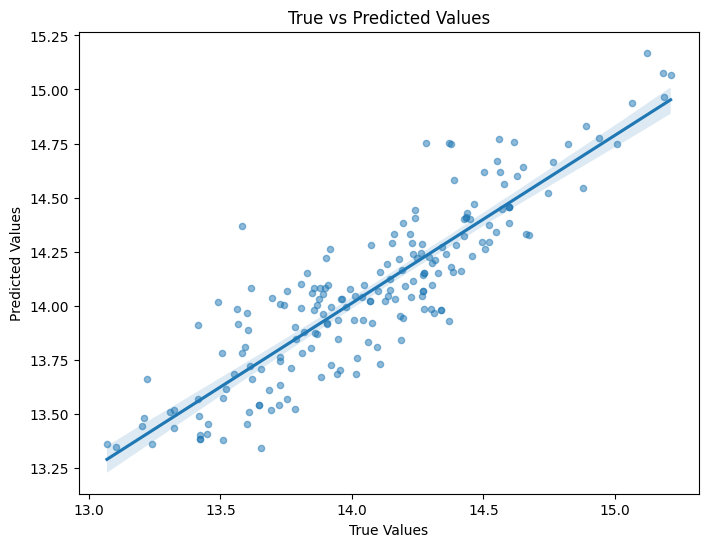

In [26]:
# 6
# Predict on combined test data
y_pred_combined = model_combined.predict(X_test_combined)

# Ensure y_test is a 1D array
y_test = np.ravel(y_test)

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred_combined)
sns.regplot(x=y_test, y=y_pred_combined, scatter_kws={'s': 20, 'alpha':0.5})
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

**Do the predicted values and true values roughly line up along the diagonal, or not?**
Yes, most of my predicted values do line up around the diagonal line. As expected, the strength of htis statement weakens as we get further from the middle of the true values. Once these values reach 13.5ish and 14.75ish, the error widens.

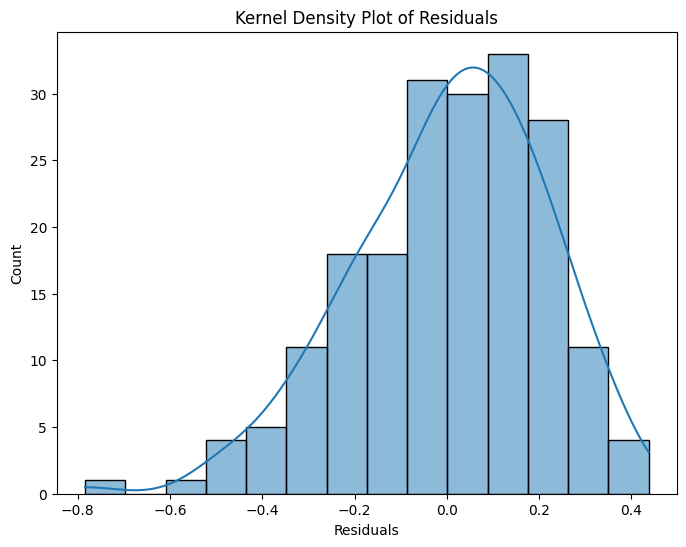

In [27]:
# 6 cont.
# Compute residuals/errors
residuals = y_test - y_pred_combined

# Kernel density plot of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Kernel Density Plot of Residuals')
plt.xlabel('Residuals')
plt.show()

**Do the residuals look roughly bell-shaped around zero?**

Yes, the residuals look normally distributed, with maybe a slight left skewness. It is fairly clear that the residuals seem to have a standard deviation of ~0.2.

In [28]:
# 7 - Decision Tree
# Create feature and target matrices
X = car_df.drop(['Price'], axis=1)
y = car_df['Price']

depths = [1,2,3,4,5,6,7,8,9,10]

# For loop for computing the R^2 and RMSE for each Max Depth
for depth in depths:

  dt = DecisionTreeRegressor(max_depth=depth, random_state=42)

  dt.fit(X_train, y_train) # Switch to X_train_combined but needs to be onehotencoded

  y_pred = dt.predict(X_test)

  r2 = dt.score(X_test, y_test)
  mse = mean_squared_error(y_test, y_pred)

  print("Max Depth (Numeric) {}: R2={:.4f}, RMSE={:.4f}".format(depth, r2, np.sqrt(mse)))

Max Depth (Numeric) 1: R2=0.2775, RMSE=0.3691
Max Depth (Numeric) 2: R2=0.3575, RMSE=0.3481
Max Depth (Numeric) 3: R2=0.4180, RMSE=0.3313
Max Depth (Numeric) 4: R2=0.4259, RMSE=0.3291
Max Depth (Numeric) 5: R2=0.3943, RMSE=0.3380
Max Depth (Numeric) 6: R2=0.3893, RMSE=0.3394
Max Depth (Numeric) 7: R2=0.3878, RMSE=0.3398
Max Depth (Numeric) 8: R2=0.3176, RMSE=0.3588
Max Depth (Numeric) 9: R2=0.3502, RMSE=0.3501
Max Depth (Numeric) 10: R2=0.1703, RMSE=0.3956


**What depth tree gives the best results?**

From the For loop, it is clear that the max depth that produces the best fitted model is Max Depth = 4.

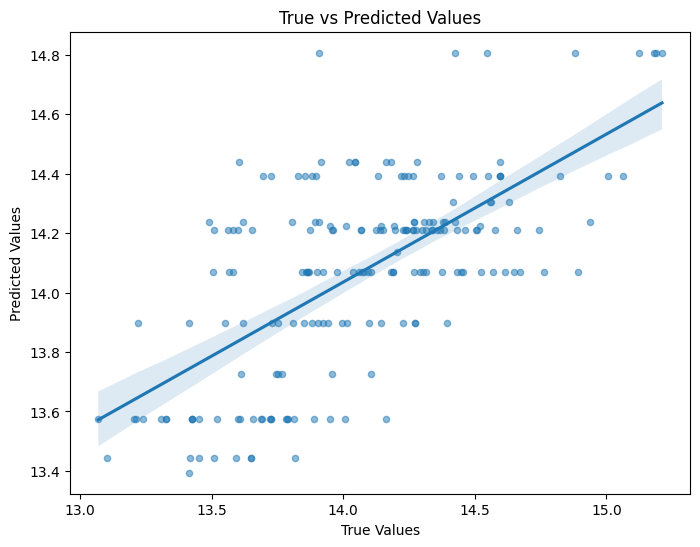

In [29]:
# 8
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)

# Predict on combined test data
y_pred_dt = dt.predict(X_test)

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred_dt)
sns.regplot(x=y_test, y=y_pred_dt, scatter_kws={'s': 20, 'alpha':0.5})
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

**Do the predicted values and true values line up along the diagonal, or not?**


Similarly to the linear model, the predicet values do roughly line up with the diagonal, but hte relationship is obviously much weaker, making this tree model slightly inferior to the linear model. The error band is significantly wider than the linear model at every point in the graph.

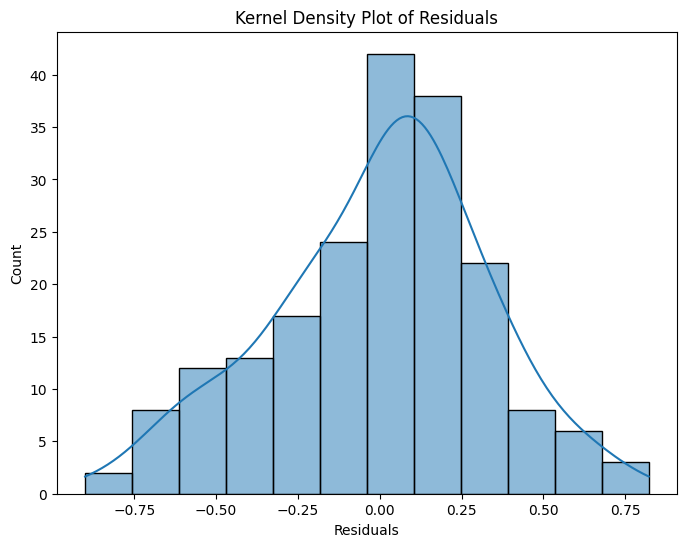

In [30]:
# 8 cont.
# Compute residuals/errors
residuals = y_test - y_pred_dt

# Kernel density plot of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Kernel Density Plot of Residuals')
plt.xlabel('Residuals')
plt.show()

**Do the residuals look roughly bell-shaped around zero?**


In a similar comparison to the predicted values graph, the residual graph of the linear model is slightly, but distinguishably better than the residual plot of the tree model.

**Which model - linear model or classification and regression tree - has better performance on the test set?**

The tree model's plot of the residuals is noticably more skewed left than the linear model. This fact combined with the results from the predicted values graph, proves that the linear model is a clear better option for the performance on the test set of data.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [31]:
# 1 Load the ./data/contraception_hw.csv data. Look at the head and dimensions of the data.
cmc_df = pd.read_csv('./assignment4/data/contraception_hw.csv')
cmc_df.head()

,Unnamed: 0,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,method
0,1,24,2,3,3,1,1,2,3,0,1
1,2,45,1,3,10,1,1,3,4,0,1
2,3,43,2,3,7,1,1,3,4,0,1
3,4,42,3,2,9,1,1,3,3,0,1
4,5,36,3,3,8,1,1,3,2,0,1


In [32]:
# 1 cont.

# Tabulate 'Method' using value counts
cmc_df['method'].value_counts()

1    629
3    511
2    333
Name: method, dtype: int64

In [33]:
# 1 cont.
# Crosstab 'Method' and 'Number of Children'
pd.crosstab(cmc_df['method'], cmc_df['numberChildren'])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


**Do couples that use birth control tend to have more children than those who don't?**

While there is adequate variation between each level, the data as a whole suggests that couples using long term contraception (method 2) tend to have fewer children compared to those who didn't use contraception (method 1) or those who used short term contraception (method 3). Couples using short term contraception have a more varied distribution of children but still show a tendency towards having fewer children compared to those without contraception.

In [34]:
# 2 - Split Dataset
# Split the data into an 80% training set and a 20% testing set
X = cmc_df.drop(columns=['method'])
y = cmc_df['method']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[Text(0.3333333333333333, 0.9, 'x[0] <= 416.5\nsquared_error = 0.773\nsamples = 1178\nvalue = 1.93'),
 Text(0.2222222222222222, 0.7, 'squared_error = 0.0\nsamples = 333\nvalue = 1.0'),
 Text(0.4444444444444444, 0.7, 'x[0] <= 1000.5\nsquared_error = 0.602\nsamples = 845\nvalue = 2.297'),
 Text(0.2222222222222222, 0.5, 'x[0] <= 642.5\nsquared_error = 0.235\nsamples = 462\nvalue = 2.621'),
 Text(0.1111111111111111, 0.3, 'squared_error = 0.0\nsamples = 175\nvalue = 2.0'),
 Text(0.3333333333333333, 0.3, 'squared_error = 0.0\nsamples = 287\nvalue = 3.0'),
 Text(0.6666666666666666, 0.5, 'x[0] <= 1214.5\nsquared_error = 0.764\nsamples = 383\nvalue = 1.906'),
 Text(0.5555555555555556, 0.3, 'squared_error = 0.0\nsamples = 166\nvalue = 1.0'),
 Text(0.7777777777777778, 0.3, 'x[0] <= 1320.5\nsquared_error = 0.24\nsamples = 217\nvalue = 2.599'),
 Text(0.6666666666666666, 0.1, 'squared_error = 0.0\nsamples = 87\nvalue = 2.0'),
 Text(0.8888888888888888, 0.1, 'squared_error = 0.0\nsamples = 130\nvalue 

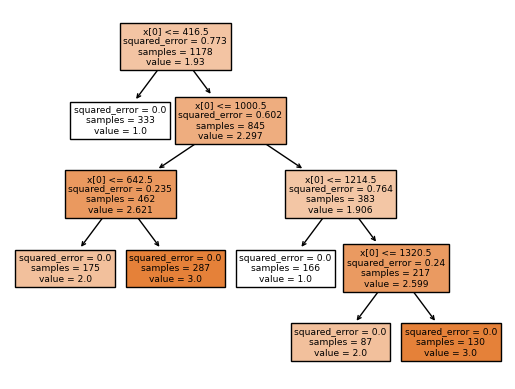

In [35]:
# 3 - Train Regression Tree
reg_tree = tree.DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

tree.plot_tree(reg_tree,filled=True)

**What values do they take? Does that make sense? Explain clearly what has gone wrong here.**

Using the DecisionTreeRegressor treats categories as ordered numeric values. This assumes an artificial ordering/proximity for categories that are unordered, giving us the values of 1.0-3.0. Categorical splits also may overfit on frequency patterns rather than generalizable category differences.

[Text(0.25, 0.9166666666666666, 'x[0] <= 416.5\ngini = 0.646\nsamples = 1178\nvalue = [499, 262, 417]'),
 Text(0.125, 0.75, 'gini = 0.0\nsamples = 333\nvalue = [333, 0, 0]'),
 Text(0.375, 0.75, 'x[0] <= 642.5\ngini = 0.622\nsamples = 845\nvalue = [166, 262, 417]'),
 Text(0.25, 0.5833333333333334, 'gini = 0.0\nsamples = 175\nvalue = [0, 175, 0]'),
 Text(0.5, 0.5833333333333334, 'x[0] <= 1000.5\ngini = 0.534\nsamples = 670\nvalue = [166, 87, 417]'),
 Text(0.375, 0.4166666666666667, 'gini = 0.0\nsamples = 287\nvalue = [0, 0, 287]'),
 Text(0.625, 0.4166666666666667, 'x[0] <= 1214.5\ngini = 0.645\nsamples = 383\nvalue = [166, 87, 130]'),
 Text(0.5, 0.25, 'gini = 0.0\nsamples = 166\nvalue = [166, 0, 0]'),
 Text(0.75, 0.25, 'x[0] <= 1320.5\ngini = 0.48\nsamples = 217\nvalue = [0, 87, 130]'),
 Text(0.625, 0.08333333333333333, 'gini = 0.0\nsamples = 87\nvalue = [0, 87, 0]'),
 Text(0.875, 0.08333333333333333, 'gini = 0.0\nsamples = 130\nvalue = [0, 0, 130]')]

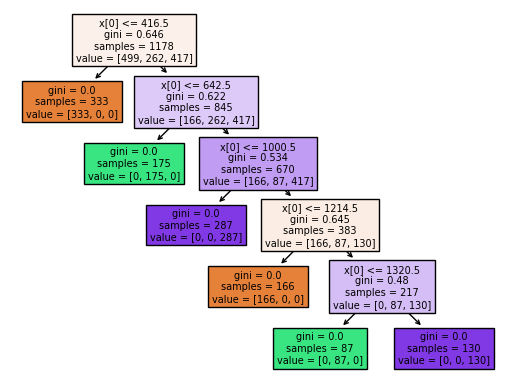

In [36]:
# 4 - Train Classification Tree
class_tree = tree.DecisionTreeClassifier()
class_tree.fit(X_train, y_train)

tree.plot_tree(class_tree,filled=True)

**How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?**

At first glance, this Classification Tree looks more colorful than the Regression Tree. This is because the nodes of the Classification Tree show gini impurity scores rather than MSE/variance estimates, using them to measure quality of splits. The leaf nodes show counts of each class rather than mean response value. The Classification tree is also splitting based on a single variable x[0], giving it hte ability to split binary at each node as compared to the Regression tree that is split multiway.

Node 1: Women with x[0] <= 416.5 look to be slightly more likely to use no contraception (class 0).

Node 3: Women with x[0] > 416.5 and <= 642.5 predominantly use short-term contraception (class 1).

Node 5: Women with x[0] > 642.5 and <= 1000.5 mostly use short-term contraception still.

Node 7: Women with x[0] > 1000.5 and <= 1214.5 look to be slightlymore likely to use no contraception.

Node 9: Women with x[0] > 1214.5 and <= 1320.5 tend to use short-term contraception.

In [37]:
# 5 - Create a Confusion Matrix
# Generate predictions
y_hat = class_tree.predict(X_test)

# Compute Matrix
tab = pd.crosstab(y_test, y_hat, rownames=['Observed'], colnames=['Predicted'])
print(tab)

# Compute Accuracy
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0])
print('Accuracy: ', acc, '\n')

# Accuracies for each class
class_acc = tab.apply(lambda x: x/x.sum(), axis=1)
print('\nAccuracy by Class:')
print(class_acc)

Predicted    1   2   3
Observed              
1          130   0   0
2            1  70   0
3            0   0  94
Accuracy:  0.9950248756218906 


Accuracy by Class:
Predicted         1         2    3
Observed                          
1          1.000000  0.000000  0.0
2          0.014085  0.985915  0.0
3          0.000000  0.000000  1.0


# 6
**Why can't you use a linear probability model to do this exercise?**

Because of nature of our response variable (Contraception Method) has three levels (1 - No Contraception, 2 - Long Term , and 3 Short Term), a linear probability model would not be the most adequate approach to a multi-class categorical variable could result in a less interpretable and potentially biased model. Linear probability models also assume a linear relationship between the predictors and the probability of the outcome being in a particular category. This linearity assumption may not be fully satisfied because of these three levels in our response variable.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?